# LAND PRICE PREDICTION APP USING AWS SAGEMAKER'S IN-BUILT XGBOOST  - End-to-End
We will build a Land Price Prediction App to help people looking to buy land in Cameroon, get the expected price of land per quartier they intend to buy land from.
The following steps will be taken:
- I)   PROBLEM STATEMENT:

Many people in Cameroon want to buy lands and they have trouble getting information on what to expect as price per square metre for the quartier they want to buy the land from.They also want to be able to consult the prices of several quartiers before making their final choice.
This is a difficult process in Cameroon as it will mean these people who want to buy lands will have to go about making many phone calls to people asking them the price of land in those quartiers.
So the objective is to scrape the data already available on the biggest Classified adds website in Cameroon (Jumia Cameroon) https://www.jumia.cm/en/land-plots

This data will be cleaned and trained using the in-built XGBoost Algorithm on AWS Sagemaker, and an endpoint will be created in AWS ,which wll be used to make predictions when given the inputs like 
- The Quartier the customer wants to buy land from
- The size of the land the customer intends to buy (in metres square)
- And the output of the model will be the predicted Price per metres square for the Quartier the customer requested.


- II)   SCRAPING THE DATA:

Scrape the data from a Classified ads website, where people post lands for sale per quartier in Cameroon.They typically type in the price per metres square and the total area of the land availlable for sale.
- III)  PERFORM EXPLORATORY DATA ANALYSIS 

Inspect the data to validate the quality of the data scraped from the classified ads website. Analyse the distribution of missing values, outliers and gain other relevant insights from the model
- IV) DO FEATURE ENGINEERING & SELECTION

Handle the mising values, outliers and do the necessary transformations which will ensure the data is well suited for the machine learning model.And also to maximise the insights gotten from the Exploratory Data Analysis phase.
- V)  BUILD,TRAIN AND DEPLOY THE MODEL IN SAGEMAKER

The Boto3 Container will be used to create the S3 buckets to store the preprocessed dataset.The Sagemaker's inbuilt XGBoost algorithm, will be built, trained and deployed.Including the use of optimal hyperparameters to get the best results for the RMSE( Root Mean Squared Error).An Endpoint will be created after the model is built.
The Endpoint created awill be used to predict the price per metre square when the inputs of "Quartier" and "Land size" are fed to the endpoint.

### IV) FEATURE ENGINEERING & SELECTION
We will perform the following tasks in order to successfully complete the Feature Engineering
- a.) Importing the necessary Libraries and scraped data
- b.) Fixing the "Price" data entry inconsistencies
- c.) Train test split
- d.) Missing Values Treatment
- e.) Outliers Treatment
- f.) Categorical Variable Treatment
- g.) Preparing and exporting train data as a CSV
- h.) Preparing and exporting test data as a CSV

#### a.) Importing the necessary Libraries

In [2]:
#Importing libraries we will need in this phase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
#View the first 5 observations
dataset = pd.read_csv("land_price_data.csv",index_col = 0)

print(dataset.head())

   Price Location     Area
0   8000   Douala  10000.0
1  55000    Yassa    300.0
2  55000    Yassa    200.0
3  55000   Japoma    735.0
4  55000   Japoma   1500.0


In [4]:
#View the shape of the data
dataset.shape

(4490, 3)

#### b.) Fixing the "Price" data entry inconsistencies

From the previous phase of the Exploratory Data Analysis, we noticed that data coming form the classified ads were having some inconsistencies in the "Price" variabl.While some prices were enetered as "Price per metres square" others were entered as the total sales amout of "price per m2 * area" some inconsistencies.So we will start by trying to fix that before splitting the data to train and test set.

In [5]:
#Viewing the descriptive statistics for the "Price" column
print(dataset.Price.describe())

count    4.490000e+03
mean     4.961029e+07
std      8.482607e+08
min      0.000000e+00
25%      1.000000e+04
50%      3.500000e+04
75%      5.000000e+05
max      4.500000e+10
Name: Price, dtype: float64


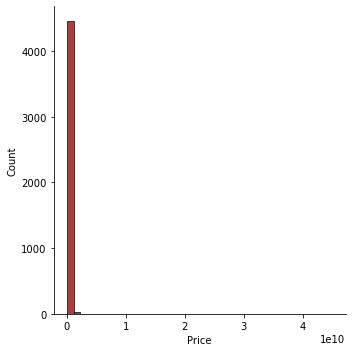

In [6]:
#Plot to see the distribution of Price
sns.displot(dataset['Price'].dropna(),kde=False,color='darkred',bins=40)

In [7]:
#Create new column for Prices above the 75th percentile and divide by Area to correct the inconsistencies seen in the EDA
dataset['Price2'] = np.where(dataset['Price'] > 500000 ,round(dataset['Price']/ dataset['Area']) , dataset['Price'])
print(dataset)

      Price  Location     Area   Price2
0      8000    Douala  10000.0   8000.0
1     55000     Yassa    300.0  55000.0
2     55000     Yassa    200.0  55000.0
3     55000    Japoma    735.0  55000.0
4     55000    Japoma   1500.0  55000.0
...     ...       ...      ...      ...
4485   6500     Yassa    150.0   6500.0
4486  17000    Tsinga   1000.0  17000.0
4487  50000  Bonaberi    300.0  50000.0
4488  50000  Bonaberi   1000.0  50000.0
4489  65000  Bonaberi    500.0  65000.0

[4490 rows x 4 columns]


In [8]:
#Cuttoff thresholds to reduce outliers from the extemeties
min_threshold,max_threshold = dataset["Price2"].quantile([0.005,0.985])
min_threshold,max_threshold

(137.25, 500000.0)

In [9]:
#Take a look at the obsevations below the min cuttoff
dataset[dataset.Price2<min_threshold]

,Price,Location,Area,Price2
104,650000,Soa,400000.0,2.0
212,10000000,PK12,120000.0,83.0
358,1500000,Foumbot,50000.0,30.0
970,900000,Limbé,10000.0,90.0
1305,7000000,Kribi,200000.0,35.0
1884,3000000,Yabassi,500000.0,6.0
2061,3500000,PK33,32000.0,109.0
2076,3000000,Yabassi,50000.0,60.0
2171,3000000,Yabassi,30000.0,100.0
2172,3000000,Yabassi,30000.0,100.0


In [10]:
#Take a look at the observations above the max cuttoff
dataset[dataset.Price2>max_threshold]

,Price,Location,Area,Price2
21,200000000,Bonamoussadi,300.0,666667.0
138,300000000,Akwa,449.0,668151.0
150,200000000,Bonamoussadi,300.0,666667.0
386,600000000,Bali,500.0,1200000.0
540,950000000,Bonapriso,886.0,1072235.0
589,160000000,Akwa,304.0,526316.0
628,340000000,Bonapriso,363.0,936639.0
1266,700000000,Bonapriso,832.0,841346.0
1401,1500000000,Yaoundé,1500.0,1000000.0
1464,918000000,Bonanjo,918.0,1000000.0


In [11]:
#Create a new dataset within the cuttoffs
dataset = dataset[(dataset.Price2>min_threshold) & (dataset.Price2<max_threshold)]
dataset.shape

(4341, 4)

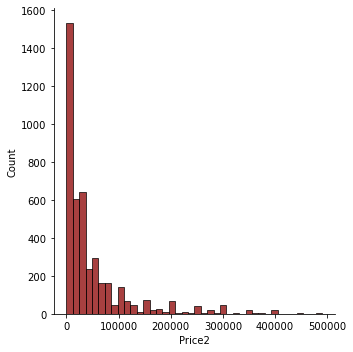

In [12]:
#Plot to see the distribution of Price
sns.displot(dataset['Price2'].dropna(),kde=False,color='darkred',bins=40)

So now we have corrected the inconsistencies, especially for the high values.Now the dataset has greatly improved.It still has outliers, but that is also because house prices in some neighbourhoods at the heart of the city are very expensive.

Next, let us move on to split the data between train and test datasets to avoid data leakage.

#### c.) Train test split

In [13]:
# Preparing the Dependent Variables
X = dataset.loc[:,['Location','Area']]
X.head()

,Location,Area
0,Douala,10000.0
1,Yassa,300.0
2,Yassa,200.0
3,Japoma,735.0
4,Japoma,1500.0


In [14]:
# Preparing the Independent Variable
y = dataset.loc[:,['Price2']]
y.head()

,Price2
0,8000.0
1,55000.0
2,55000.0
3,55000.0
4,55000.0


In [15]:
# Use scikit learn to split the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [16]:
# Creating one training dataset
train_set = pd.concat([X_train,y_train],axis = 1)
train_set

,Location,Area,Price2
166,Logbessou,400.0,38000.0
1910,Odza,2000.0,27000.0
998,Douala,10000.0,8000.0
1620,PK19,500.0,25000.0
599,Yaoundé,200000.0,175000.0
...,...,...,...
1054,Limbé,625.0,12000.0
3370,PK26,500.0,4500.0
1687,Japoma,356.0,35000.0
2684,Bamenda,400.0,8750.0


We now have the training set.Let us move on to treating the missing values in the "Area" variable.

#### d.) Treating Missing Values

In [17]:
#View the count of the Area Variable compared to the count of Price2 
train_set.describe()

,Area,Price2
count,3317.000000,3472.000000
mean,8518.085017,51066.985023
std,35277.571545,72689.427991
min,0.000000,150.000000
25%,500.000000,8000.000000
50%,1000.000000,25000.000000
75%,5000.000000,60000.000000
max,500000.000000,490884.000000


In [18]:
#Import scikit learn imputer to impute the median
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan,strategy='median')

In [19]:
#Fit and transform the Area Varible with the meedian value
train_set['Area'] = imp.fit_transform(train_set[['Area']])
train_set.describe()

,Area,Price2
count,3472.000000,3472.000000
mean,8182.456221,51066.985023
std,34515.851876,72689.427991
min,0.000000,150.000000
25%,500.000000,8000.000000
50%,1000.000000,25000.000000
75%,5000.000000,60000.000000
max,500000.000000,490884.000000


Missing values for Area have been replaced by the median Area (which is 1000 metres square).

Next let us take care of the outliers in the dependent variable.This will help reduce the bias from the machine learning model.

#### e.) Outliers Treatment

In [20]:
#Apply logs to the Price column 
train_set['Price_log'] = train_set.Price2.transform(np.log)
train_set.head()

,Location,Area,Price2,Price_log
166,Logbessou,400.0,38000.0,10.545341
1910,Odza,2000.0,27000.0,10.203592
998,Douala,10000.0,8000.0,8.987197
1620,PK19,500.0,25000.0,10.126631
599,Yaoundé,200000.0,175000.0,12.072541


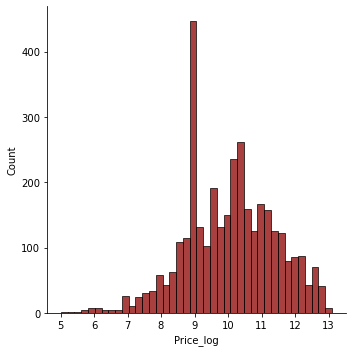

In [21]:
#Plot to see the if Price is a lognormal distribution
sns.displot(train_set['Price_log'].dropna(),kde=False,color='darkred',bins=40)

After taking logs for the "Price" variable the distribution now looks close to Normal.

Next let us treat the categorical variables and try to isolate just the popular locations as seen in the EDA.

#### f.) Categorical Variable Treatment

<AxesSubplot:xlabel='Location', ylabel='count'>

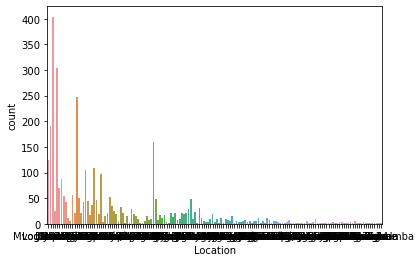

In [22]:
#Looking at the distribution of Location
sns.countplot(x='Location',data = train_set)

In [23]:
#Looking at the number of categories
print(f"The number of categories in the Location variable is : {train_set['Location'].nunique()} locations  \n ")
print(train_set['Location'].unique())

The number of categories in the Location variable is : 153 locations  
 
['Logbessou' 'Odza' 'Douala' 'PK19' 'Yaoundé' 'Makepe' 'Japoma' 'Bonaberi'
 'Village' 'Damase' 'Mvog Atangana Mballa' 'Mfou' 'PK26' 'Yassa' 'Kotto'
 'Nyalla' 'PK16' 'Lendi' 'Soa' 'Efoulan' 'PK12' 'Logpom' 'Bastos' 'PK27'
 'Limbé' 'Newtown Aeroport' 'Deido' 'Centre ville' 'Nkoabang' 'Awae'
 'Omnisports' 'Bassa' 'Eleveur' 'Edéa' 'Mendong' 'Kumba' 'Biyem-Assi'
 'New Bell' 'Ahala' 'PK33' 'Denver' 'Nsam' 'Messa' 'Kondengui' 'PK18'
 'Quartier Golf' 'Bonanjo' 'Buea' 'Kribi' 'PK21' 'Akwa Nord' 'Ndog-Bong'
 'Biteng' 'PK11' 'Etoug Ebe' 'Mvolye' 'Bonapriso' 'Nyom2' 'Nkolfoulou'
 'Mvog Ada' 'Emana' 'Mimboman' 'Nkolbisson' 'Messamendongo' 'PK14'
 'Bonamoussadi' 'Akwa' 'Cite des Palmiers' 'Bonedale' 'Olembe' 'Nyom'
 'Nsimeyong' 'Manjo' 'Obili' 'Logbaba' 'Zone Bassa' 'Bafoussam' 'Mvan'
 'PK25' 'Ndokoti' 'Ntui' 'Tsinga' 'Ngoumou' 'Mbalgong' 'Dibombari'
 'Nkoulouloum' 'Essos' 'Ndogbati' 'Ndogpassi2' 'Mbangue' 'PK20' 'Bali'
 'Mball

There are lots of categories.Which would affect the model's performance.Let us identify rare categories (those below 1% of the dataset)

In [24]:
#Checking for rare categories in Locations
category_list = train_set.groupby('Location')['Price2'].count()/len(train_set)
category_list = list(category_list[category_list>0.01].index)
print(category_list)
print(f"\n There are a total of {len(category_list)} Popular Locations.")

['Awae', 'Bastos', 'Bonaberi', 'Bonamoussadi', 'Douala', 'Japoma', 'Kotto', 'Kribi', 'Lendi', 'Limbé', 'Logbessou', 'Logpom', 'Makepe', 'Mfou', 'Nkoabang', 'Odza', 'PK12', 'PK16', 'PK21', 'Soa', 'Village', 'Yaoundé', 'Yassa']

 There are a total of 23 Popular Locations.


In [25]:
#Create new column with the new categories
train_set["Location_cat"] = np.where(np.isin(train_set["Location"],category_list),train_set["Location"],"rare")
print(train_set)

       Location      Area    Price2  Price_log Location_cat
166   Logbessou     400.0   38000.0  10.545341    Logbessou
1910       Odza    2000.0   27000.0  10.203592         Odza
998      Douala   10000.0    8000.0   8.987197       Douala
1620       PK19     500.0   25000.0  10.126631         rare
599     Yaoundé  200000.0  175000.0  12.072541      Yaoundé
...         ...       ...       ...        ...          ...
1054      Limbé     625.0   12000.0   9.392662        Limbé
3370       PK26     500.0    4500.0   8.411833         rare
1687     Japoma     356.0   35000.0  10.463103       Japoma
2684    Bamenda     400.0    8750.0   9.076809         rare
2812      Yassa    3000.0   10000.0   9.210340        Yassa

[3472 rows x 5 columns]


In [26]:
#Doing one hot encoding to the Location categories
Location_dummies = pd.get_dummies(train_set["Location_cat"])
Location_dummies

,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,Kotto,Kribi,Lendi,Limbé,...,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa,rare
166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1687,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
#Add the one hot encoded columns to the training set
train_set = pd.concat([train_set,Location_dummies],axis = 1)
train_set

,Location,Area,Price2,Price_log,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,...,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa,rare
166,Logbessou,400.0,38000.0,10.545341,Logbessou,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,Odza,2000.0,27000.0,10.203592,Odza,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
998,Douala,10000.0,8000.0,8.987197,Douala,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1620,PK19,500.0,25000.0,10.126631,rare,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
599,Yaoundé,200000.0,175000.0,12.072541,Yaoundé,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,Limbé,625.0,12000.0,9.392662,Limbé,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3370,PK26,500.0,4500.0,8.411833,rare,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1687,Japoma,356.0,35000.0,10.463103,Japoma,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2684,Bamenda,400.0,8750.0,9.076809,rare,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
#Dropping the columns titled "Location" and "rare"
train_set = train_set.drop(['Location','rare'],axis = 1)
train_set

,Area,Price2,Price_log,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,...,Mfou,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa
166,400.0,38000.0,10.545341,Logbessou,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,2000.0,27000.0,10.203592,Odza,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
998,10000.0,8000.0,8.987197,Douala,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1620,500.0,25000.0,10.126631,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,200000.0,175000.0,12.072541,Yaoundé,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,625.0,12000.0,9.392662,Limbé,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3370,500.0,4500.0,8.411833,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1687,356.0,35000.0,10.463103,Japoma,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2684,400.0,8750.0,9.076809,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### g.) Preparing and Exporting the train dataset as CSV

In [29]:
#Dropping the "Location_cat" and "Price2" columns 
train_set = train_set.drop(['Location_cat','Price2'],axis = 1)
train_set

,Area,Price_log,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,Kotto,Kribi,...,Mfou,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa
166,400.0,10.545341,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,2000.0,10.203592,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
998,10000.0,8.987197,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1620,500.0,10.126631,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599,200000.0,12.072541,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,625.0,9.392662,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3370,500.0,8.411833,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1687,356.0,10.463103,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2684,400.0,9.076809,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Exporting the "train_set" as CSV and naming it "train" to be used in Sagemaker in the next phase
train_set.to_csv("train_clean.csv", sep='\t', encoding='utf-8',index=False)

We have now saved our cleaned train dataset (train.csv) which will be used in the next phase in Sagemaker when building the model and training the model.

Next, let us also prepare the test dataset which will also be used in the next hase to test the model performance in Sagemaker.
We would also need to apply the same feature engineering we did for the training dataset, to this test dataset before exporting the "test.csv" file.

#### h.) Preparing and Exporting the test dataset as CSV

In [31]:
#View the X_test data set after the train test split above
X_test.head()

,Location,Area
3909,Kotto,800.0
3804,Olembe,500.0
3937,Tropicana,500.0
573,Limbé,630.0
1108,Logpom,400.0


In [32]:
# Creating one test dataset
test_set = pd.concat([X_test,round(y_test,0)],axis = 1)
test_set

,Location,Area,Price2
3909,Kotto,800.0,85000.0
3804,Olembe,500.0,16000.0
3937,Tropicana,500.0,80000.0
573,Limbé,630.0,20635.0
1108,Logpom,400.0,87500.0
...,...,...,...
1524,Bonaberi,2000.0,25000.0
3109,Messassi,2200.0,15000.0
3065,PK21,9000.0,5000.0
2722,Odza,1500.0,16000.0


In [33]:
#Check the count to see the number of missing observations for Area
test_set.describe()

,Area,Price2
count,846.000000,869.000000
mean,12232.199764,46406.357883
std,49272.200611,63163.363930
min,26.000000,255.000000
25%,500.000000,8000.000000
50%,1000.000000,24887.000000
75%,10000.000000,60000.000000
max,500000.000000,400000.000000


In [34]:
#Treating Missing Values by using same parameters like with the training
test_set['Area'] = imp.transform(X_test[['Area']])

In [35]:
#Checking count again to be sure missing values have been imputed
test_set.describe()

,Area,Price2
count,869.000000,869.000000
mean,11934.914845,46406.357883
std,48648.478999,63163.363930
min,26.000000,255.000000
25%,500.000000,8000.000000
50%,1000.000000,24887.000000
75%,9000.000000,60000.000000
max,500000.000000,400000.000000


In [36]:
# Adding Location in Category List
test_set["Location_cat"] = np.where(np.isin(test_set["Location"],category_list),test_set["Location"],"rare")
print(test_set)

       Location    Area   Price2 Location_cat
3909      Kotto   800.0  85000.0        Kotto
3804     Olembe   500.0  16000.0         rare
3937  Tropicana   500.0  80000.0         rare
573       Limbé   630.0  20635.0        Limbé
1108     Logpom   400.0  87500.0       Logpom
...         ...     ...      ...          ...
1524   Bonaberi  2000.0  25000.0     Bonaberi
3109   Messassi  2200.0  15000.0         rare
3065       PK21  9000.0   5000.0         PK21
2722       Odza  1500.0  16000.0         Odza
938   Logbessou   500.0  60000.0    Logbessou

[869 rows x 4 columns]


In [37]:
Location_dummies = pd.get_dummies(test_set["Location_cat"])
Location_dummies

,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,Kotto,Kribi,Lendi,Limbé,...,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa,rare
3909,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
573,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3065,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2722,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [38]:
test_set = pd.concat([test_set,Location_dummies],axis = 1)
test_set

,Location,Area,Price2,Location_cat,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,...,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa,rare
3909,Kotto,800.0,85000.0,Kotto,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3804,Olembe,500.0,16000.0,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3937,Tropicana,500.0,80000.0,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
573,Limbé,630.0,20635.0,Limbé,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,Logpom,400.0,87500.0,Logpom,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,Bonaberi,2000.0,25000.0,Bonaberi,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3109,Messassi,2200.0,15000.0,rare,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3065,PK21,9000.0,5000.0,PK21,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2722,Odza,1500.0,16000.0,Odza,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [39]:
test_set = test_set.drop(['Location','Location_cat','rare'],axis = 1)

In [40]:
test_set.head()

,Area,Price2,Awae,Bastos,Bonaberi,Bonamoussadi,Douala,Japoma,Kotto,Kribi,...,Mfou,Nkoabang,Odza,PK12,PK16,PK21,Soa,Village,Yaoundé,Yassa
3909,800.0,85000.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3804,500.0,16000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3937,500.0,80000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
573,630.0,20635.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,400.0,87500.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
test_set.to_csv('test_clean.csv',sep='\t', encoding='utf-8',index=False)

Great!!! We have finally saved 02 CSV files (train.csv and test.csv) which we will use in the next phase to build, train and deploy our model through AWS Sagemaker.

Now it is time to head over to our AWS account for the next phase.